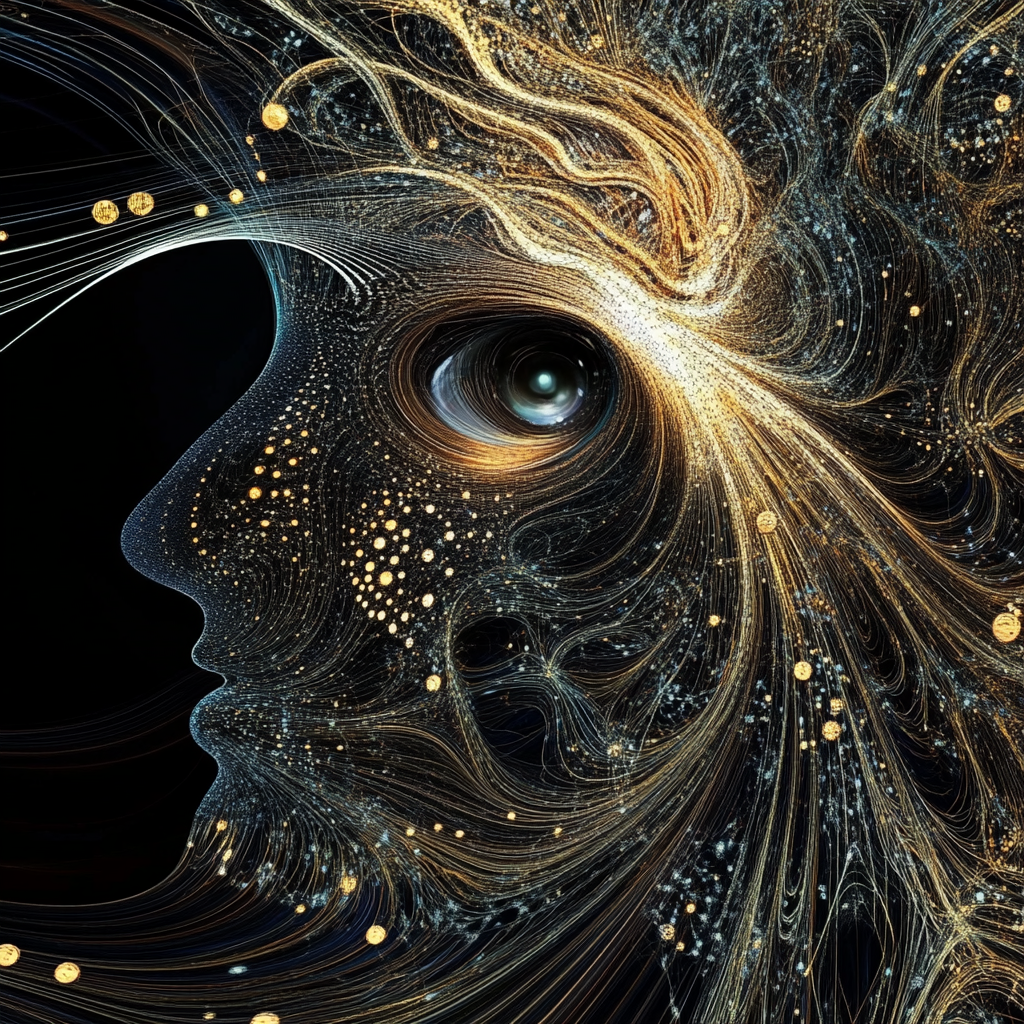

# Hopfield Nobel Nets
This is the second notebook. For a beginner-friendly introduction to implementing Hopfield networks, please check out the first notebook and accompaning medium article (https://medium.com/p/a08dc7dd63bb).

Here, in the second notebook, we’ll implement Hopfield networks with Keras to recover (denoise) a continuous pattern from a highly noisy signal.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Input
import matplotlib.pyplot as plt

### Training Step
We calculate the weight matrix using Hebbian learning (outer product of patterns). In Hebbian learning, the idea is that **"neurons that fire together, wire together."**  The weight between two neurons is increased proportionally to their activations.

* Training: You adjust the weights between neurons so that the network stores these two patterns. The weights are updated using **Hebbian learning**:

$$
w_{ij} = \frac{1}{n} \sum_p x_i^p \cdot x_j^p
$$

where $x_i^p$ is the $i$-th neuron of the $p$-th pattern, and $n$ is the number of patterns.




❌`Keras` does not perform any learning in the traditional sense (like backpropagation and gradient descent) using `model.fit()` function in the Keras API❌.

#### Key Steps
**Hebbian Learning**: The weight matrix is built by summing the outer products of the training patterns.

**Reconstruction**: The network uses the weight matrix to update neuron states and recover stored patterns from noisy inputs.

#### Python code for Hebbian Learning
Here is the Python code implementing these steps :

In [ ]:
# Hopfield-like update rule: Hebbian learning
def hebbian_learning(patterns):
    num_neurons = patterns.shape[1]
    weights = np.zeros((num_neurons, num_neurons))
    for p in patterns:
        weights += np.outer(p, p)

    if False:
      np.fill_diagonal(weights, 0)  # No self-connections
    else:
      weights = (weights / patterns.shape[0]) - np.eye(num_neurons)
    return weights

##### Regularize the Weights
**Problem**: Large noise can disturb the network's weight matrix.

**Solution**: Regularize the weights by adding a small regularization term to the weight update rule. This helps prevent the network from being overly influenced by any single pattern.

**Tip**: try both learning rules (`hebbian_learning` vs `hebbian_learning_with_regularization`) and compare the results...

In [ ]:
def hebbian_learning_with_regularization(patterns, reg_strength=0.01):
    num_neurons = patterns.shape[1]
    weights = np.zeros((num_neurons, num_neurons))
    for p in patterns:
        weights += np.outer(p, p)
    weights = (weights / patterns.shape[0]) - reg_strength * np.eye(num_neurons)
    return weights

### Build Model
`build_model` creates a simple neural network using Keras with a single `dense layer`.
* input shape matches the dimensions of the provided weight matrix.
* The `weights` argument : the weights learned through Hebbian learning, which are directly set for the model's layer
* activation function is customizable (defaulting to `tanh`).

This setup provides a minimal Hopfield network for tasks like pattern recognition.

In [ ]:
def build_model(weights , activation  = 'tanh'):
  # Build a minimal Keras model with custom weight initialization
  model = Sequential([
    Input(shape=(weights.shape[0],)),
    Dense(weights.shape[0], activation = activation, use_bias = False)])
   # Set the weights learned by Hebbian learning
  model.layers[0].set_weights([weights])
  return model

## Hopfield Nobel Nets for Time Serie

### Reconstruct Noisy Sine Wave

In [ ]:
# Generate a time series (sine wave)
def generate_sine_wave(num_points=1000, frequency=1, noise_level=0.9):
    x = np.linspace(0, 5 * np.pi * frequency, num_points)
    sine_wave = np.sin(x)
    noisy_sine_wave = sine_wave + np.random.uniform(-noise_level, noise_level, num_points)
    return sine_wave, noisy_sine_wave

In [ ]:
# Generate and visualize the sine wave time series
sine_wave, noisy_sine_wave = generate_sine_wave(num_points=200 , noise_level=0.1)

In [ ]:
# Hopfield network expects patterns, so we treat the time series points as a pattern
patterns = np.array([sine_wave])

In [ ]:
# Initialize the network weights
weights = hebbian_learning_with_regularization(patterns)

For `'tanh'` activation function, the reconstructed output mainly consists of values close to -1, 0, or 1 is due to the use of the `tanh` activation function in the model. The `tanh` function outputs values in the range of
`[−1,1]`, but it tends to saturate near those extreme values for inputs with large magnitudes.

We can try a `linear` activation function to allow a wider range of continuous outputs. This prevents saturation and might help keep intermediate values closer to their original forms.

In [ ]:
model = build_model(weights , 'sigmoid')

In [ ]:
# Test the network with a noisy sine wave input
distorted_input = noisy_sine_wave

# Run inference
reconstructed = model.predict(np.array([distorted_input]))

In [ ]:
def rescale_output(output, original_range=(-1, 1)):
    output_min, output_max = np.min(output), np.max(output)
    scale_min, scale_max = original_range
    scaled_output = (output - output_min) / (output_max - output_min) * (scale_max - scale_min) + scale_min
    return scaled_output
reconstructed = rescale_output(reconstructed)

In [ ]:
# Plot real sine wave, noisy input, and reconstructed output
def plot_time_series(real, noisy, reconstructed, title):
    plt.figure(figsize=(10, 6))
    plt.plot(real, color = 'red', label='Real Sine Wave', linewidth = .8)
    plt.plot(noisy, label='Noisy Sine Wave', linewidth = 2 , alpha = 0.6 )
    plt.plot(reconstructed[0], color = 'black',label='Reconstructed Sine Wave')
    plt.legend()
    plt.title(title)
    plt.show()

# Plot the results
plot_time_series(sine_wave, noisy_sine_wave, reconstructed, "Hopfield Network for Time Series (Sine Wave)")

### Reconstruct Real Time Serie

In this example, we’re testing Hopfield networks in a continuous domain. We create a real-time series by combining several sine waves with added noise. The resulting mix of periodic waves, each with unique frequencies and phases, will act as patterns. We’ll use these patterns to denoise and reconstruct the original signal.

In [ ]:
# Generate a time series by combining multiple sine waves and adding noise
def generate_realistic_time_series(num_points=100, noise_level=0.9):
    x = np.linspace(0, 10, num_points)
    # Create a combination of multiple sine waves of different frequencies and phases
    wave1 = np.sin(2 * np.pi * 0.5 * x)  # First sine wave
    wave2 = np.sin(2 * np.pi * 1.5 * x)  # Second sine wave with higher frequency
    wave3 = np.sin(2 * np.pi * 0.25 * x + np.pi / 4)  # Third wave with phase shift

    # Combine the waves and add noise
    combined_wave = wave1 + 0.5 * wave2 + 0.25 * wave3
    noisy_wave = combined_wave + np.random.normal(0, noise_level, num_points)
    return combined_wave, noisy_wave

In [ ]:
# Generate and visualize the sine wave time series
real_wave, distorted_input = generate_realistic_time_series(num_points=200)

The resulting mix of periodic waves, each with unique frequencies and phases, along with additional (irrelevant) periodic functions, will act as patterns. The Hopfield network will attempt to extract the relevant (`sin`) fundamental periodic functions while ignoring the irrelevant ones (`cos`).

In [ ]:
# Hopfield network expects patterns, so we treat the time series points as a pattern
patterns = np.array([real_wave])
num_points = 200
x = np.linspace(0, 10, num_points)
wave3 = np.sin(2 * np.pi * 0.25 * x + np.pi/8 )
wave2 = np.sin(2 * np.pi * 1.5 * x+ np.pi/8)
wave1 = np.sin(2 * np.pi * 0.5 * x+ np.pi/8)

wave4 = np.cos(2 * np.pi * 0.25 * x + np.pi / 4)
wave5 = np.cos(2 * np.pi * 1.5 * x)
wave6 = np.cos(2 * np.pi * 0.5 * x)

patterns = np.array(np.vstack([wave1 , wave2 , wave5 , wave6]))
patterns = np.array(np.vstack([wave1 , wave2 , wave3 , wave4 , wave5 , wave6]))
patterns = np.array(np.vstack([wave1 , wave2 , wave3 , ]))

In [ ]:
# Initialize the network weights
weights = hebbian_learning_with_regularization(patterns)

In [ ]:
model = build_model(weights , 'linear')

In [ ]:
# Test the network with a noisy sine wave input
reconstructed = model.predict(np.array([distorted_input]))

In [ ]:
def rescale_output(output, original_range=(-1, 1)):
    output_min, output_max = np.min(output), np.max(output)
    scale_min, scale_max = original_range
    scaled_output = (output - output_min) / (output_max - output_min) * (scale_max - scale_min) + scale_min
    return scaled_output
reconstructed = rescale_output(reconstructed)

In [ ]:
# match reconstructed with the closest stored pattern
closest_signal = patterns[np.argmin(np.linalg.norm(patterns - reconstructed, axis=1))]

In [ ]:
# Plot real sine wave, noisy input, and reconstructed output
plt.figure(figsize=(10, 6))
plt.plot(distorted_input, '--' , label='input Wave', linewidth = 0.8 , alpha = 0.9 )
plt.plot(real_wave, color = 'red', label='clean_signal')
if False:
  plt.plot(wave1 , label = 'pattern_1', alpha = 0.3)
  plt.plot(wave2 , label = 'pattern_2', alpha = 0.3)
  plt.plot(wave3 , label = 'pattern_3', alpha = 0.3)
plt.plot(reconstructed[0], color = 'black', linewidth = 3 , label = 'Reconstructed Sine Wave')
#plt.plot(closest_signal , color = 'green' , label = 'scd_step:closest' , alpha = 0.6)
plt.legend()
plt.show()

In conclusion, while Hopfield networks may have been somewhat overlooked in recent years, the Nobel Prize recognition for Hinton and Hopfield has sparked renewed interest. These networks have unique strengths and are worth revisiting for tasks where their pattern storage and retrieval abilities are particularly well-suited.